# AE Experimentation

## Imports and Constants

In [2]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import torch.nn.functional as F
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from data_evaluation.predictive.TimeSeriesDataset import TimeSeriesDataset
from AE import LSTMAE, FCAE, train_autoencoder

In [4]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False
TEST_EXISTING_MODEL = True

In [5]:
model_name = "LSTM_AE"
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "num_epochs": 2000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [6]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "mitv_prep_1y.csv")
traffic_df.shape

(8759, 5)

In [45]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(28511, 5)

### Preprocessing

In [46]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [47]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [48]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


In [49]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [50]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [51]:
X_train, y = next(iter(train_loader))

## Autoencoder

In [52]:
if model_name == "LSTM_AE":
    model = LSTMAE().to(hyperparameters['device'])
elif model_name == "FCAE":
    model = FCAE(verbose=False).to(hyperparameters['device'])

In [53]:
if False:
    test_sample = train_seq_scaled[:32]
    
    model.eval()
    with torch.inference_mode():
        pred = model(torch.tensor(test_sample, dtype=torch.float32).to(hyperparameters['device']))
        print(pred.shape)

## Training

In [54]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.L1Loss()

In [55]:
if TEST_EXISTING_MODEL:
    model_path = f"{model_name}_best.pth"
else:
    model_path = f"{model_name}_checkpoint.pth"

    train_losses, val_losses = train_autoencoder(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        save_path=model_path
    )

## Evaluate Training

In [56]:
if not TEST_EXISTING_MODEL:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Diagramm 1 (oben links)
    axs[0].plot(train_losses, label="BCELoss")
    axs[0].set_title('Training Loss')

    axs[1].plot(val_losses, label="BCELoss")
    axs[1].set_title('Validation Loss')

In [57]:
if not TEST_EXISTING_MODEL:
    smallest_val_loss = val_losses[-11]
    smallest_train_loss = train_losses[-11]
    print(f'Smallest Val Loss: {smallest_val_loss} | Smallest Train Loss: {smallest_train_loss}')

## Testing Model

In [58]:
if model_name == "LSTM_AE":
    print("LSMT_AE")
    test_model = LSTMAE().to(hyperparameters['device'])
elif model_name == "FCAE":
    print("FCAE")
    test_model = FCAE(verbose=True).to(hyperparameters['device'])

# load model state dict
test_model.load_state_dict(torch.load(model_path))

LSMT_AE


<All keys matched successfully>

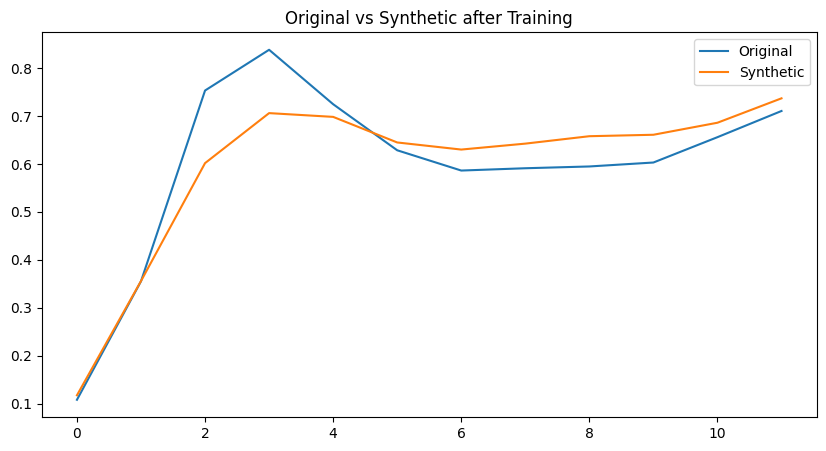

In [100]:
random_idx = random.randint(0, len(train_dataset) - 1)
random_test_sample = torch.tensor(train_dataset[random_idx][0], dtype=torch.float32).unsqueeze(0)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

test_model.eval()
with torch.inference_mode():
    test_pred = test_model(random_test_sample)

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# plot the original and synthetic test data
plt.figure(figsize=(10, 5))
plt.title(f'Original vs Synthetic after Training')
plt.plot(test_plot[0, :, 0], label='Original')
plt.plot(pred_plot[0, :, 0], label='Synthetic')
plt.legend()

In [60]:
test_model.eval()
with torch.inference_mode():
    syn_train = test_model(torch.tensor(train_seq_scaled, dtype=torch.float32))
    syn_test = test_model(torch.tensor(test_seq_scaled, dtype=torch.float32))
    syn_val = test_model(torch.tensor(val_seq_scaled, dtype=torch.float32))

In [61]:
syn_train.shape, syn_test.shape, syn_val.shape

(torch.Size([22797, 12, 5]),
 torch.Size([2840, 12, 5]),
 torch.Size([2841, 12, 5]))

In [62]:
syn_train = syn_train.detach().numpy()
syn_test = syn_test.detach().numpy()
syn_val = syn_val.detach().numpy()

In [63]:
result = np.concatenate([syn_train, syn_val, syn_test], axis=0)

In [64]:
result.shape

(28478, 12, 5)

In [65]:
result_unscaled = scaler.inverse_scale_complete_dataset(result, input_data_is_sequential=True)

In [66]:
no, seq, dim = result_unscaled.shape
data_to_save = result_unscaled.reshape(no, seq*dim)

In [67]:
# np.savetxt(f'mitv_{no}_{seq}_{dim}_autoencoder_{model_name}_unscaled.csv', data_to_save, delimiter=',')

### Check on synthetic data

In [68]:
df = pd.DataFrame(result_unscaled.reshape(-1, dim))
df.describe()

,0,1,2,3,4
count,341736.000000,341736.000000,341736.0,341736.0,341736.000000
mean,3246.958984,282.898468,0.0,0.0,41.946411
std,1898.209106,12.331297,0.0,0.0,39.537220
min,0.000000,245.715363,0.0,0.0,0.000000
25%,1342.486206,273.555267,0.0,0.0,0.000000
50%,3681.667603,284.773941,0.0,0.0,34.915749
75%,4856.334717,293.137657,0.0,0.0,88.441345
max,8375.253906,309.613892,0.0,0.0,123.771759


In [69]:
traffic_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000
